In [1]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner
import chainconsumer

import parameter_estimation_micro_qcd
import axion_mass
import g_star
import eom
import potential
import config

In [2]:
df = np.load(config.data_path + "/micro_qcd_parameter.npz")
samples = df["samples"]
single_chains = samples.reshape((-1, 5))
names = ["theta_i", "f_a"] + parameter_estimation_micro_qcd.parameter_names

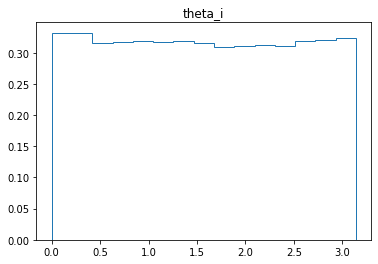

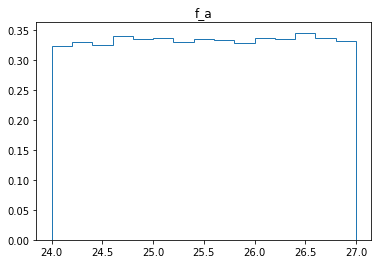

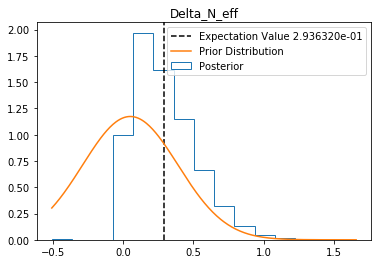

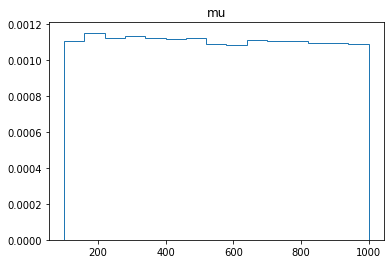

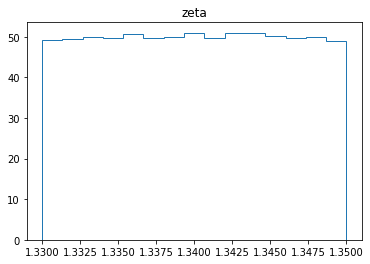

In [3]:
for i, name in enumerate(names):
    plt.title(name)
    plt.hist(single_chains[:, i], bins=15, density=True, histtype="step", label="Posterior")
    if name == "Delta_N_eff":
        Delta_N_effs = single_chains[:, i]
        Delta_N_eff_expectation_value = np.mean(Delta_N_effs)
        plt.axvline(Delta_N_eff_expectation_value, label="Expectation Value %e" % Delta_N_eff_expectation_value, 
                    color="black", linestyle="--")
        Delta_N_effs = np.linspace(np.min(Delta_N_effs), np.max(Delta_N_effs), 300)
        plt.plot(Delta_N_effs, np.exp(parameter_estimation_micro_qcd.log_gaussian(Delta_N_effs,
            parameter_estimation_micro_qcd.Delta_N_eff_mean, parameter_estimation_micro_qcd.Delta_N_eff_err)),
                label="Prior Distribution")
        plt.legend()
    plt.show()

In [36]:
#corner.corner(single_chains, labels=names)

In [4]:
mu = single_chains[:, -2]
m_psi = mu / 2
f_a = single_chains[:, 1]
m_a = np.sqrt(mu**3 * m_psi) / f_a

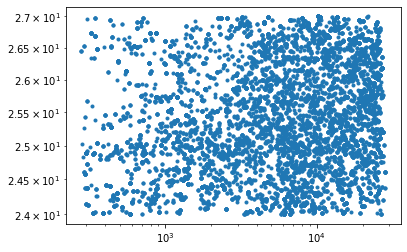

In [7]:
n = 10000
plt.loglog(m_a[:n], f_a[:n], ".")

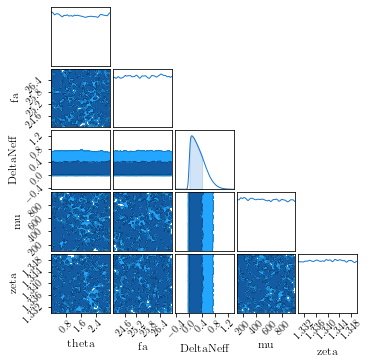

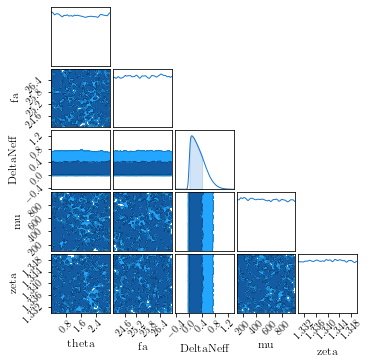

In [35]:
c = chainconsumer.ChainConsumer()
names = ["theta", "fa", "DeltaNeff", "mu", "zeta"]
c.add_chain(single_chains, parameters=names)
c.plotter.plot(filename="test.pdf", figsize="column")

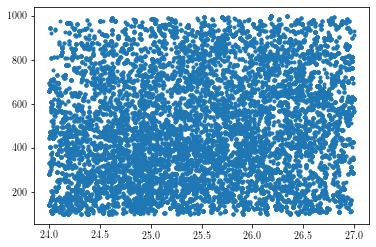

In [40]:
plt.plot(samples[0, :, 1], samples[0, :, 3], ".")

In [38]:
samples.shape

(50, 20000, 5)